In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df['sentiment_num'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,sentiment,sentiment_num
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [5]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

In [6]:
nlp.vocab['not'].is_stop = False
def preprocess_texts(texts, batch_size=128, n_process=4):
    results = []
    #since the dataset is large, using nlp.pipe will be better for faster and parallel processing
    for doc in nlp.pipe(texts, batch_size=batch_size, n_process=n_process):
        tokens = []
        for token in doc:
            if token.is_stop or token.is_punct or token.like_num:
                continue
            tokens.append(token.lemma_.lower())
        results.append(' '.join(tokens))
    return results  

In [7]:
df['preprocessed_review'] = preprocess_texts(df['review'].tolist())
df.head()

,review,sentiment,sentiment_num,preprocessed_review
0,One of the other reviewers has mentioned that ...,positive,1,reviewer mention watch oz episode hook right e...
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production < br /><br />the f...
2,I thought this was a wonderful way to spend ti...,positive,1,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,negative,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei love time money visually stunnin...


In [27]:
#some reviews have <br /> values in them. we should remove them as they dont have any meaning and will only add noise to our data
df['preprocessed_review'] = df['preprocessed_review'].str.replace('<br />', ' ', regex=False)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [29]:
x_train, x_test, y_train, y_test = train_test_split(df['preprocessed_review'], df['sentiment_num'], test_size=0.2, random_state=42)

In [30]:
lr_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logistic regression', LogisticRegression(max_iter=1000))
])

lr_clf.fit(x_train, y_train)
y_pred_lr = lr_clf.predict(x_test)
print("Logistic Regression Classification Report:\n",  classification_report(y_test, y_pred_lr))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [31]:
nb_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())    
])

nb_clf.fit(x_train, y_train)
y_prid_nb = nb_clf.predict(x_test)
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_prid_nb))

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      4961
           1       0.87      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



After checking the metrics of both the Logistic Regression and the Multinomial Naive Bayes models, the logistic regression appears to be a slightly better model overall. 
Naive Bayes performed a bit worse because it assumes words act independently and doesn’t fit as well with TF-IDF values. On the other hand, Logistic Regression can handle these patterns more accurately and is better suited with TF-IDF than Naive Bayes.

##  Visualizing the most frequent positive and negative words 

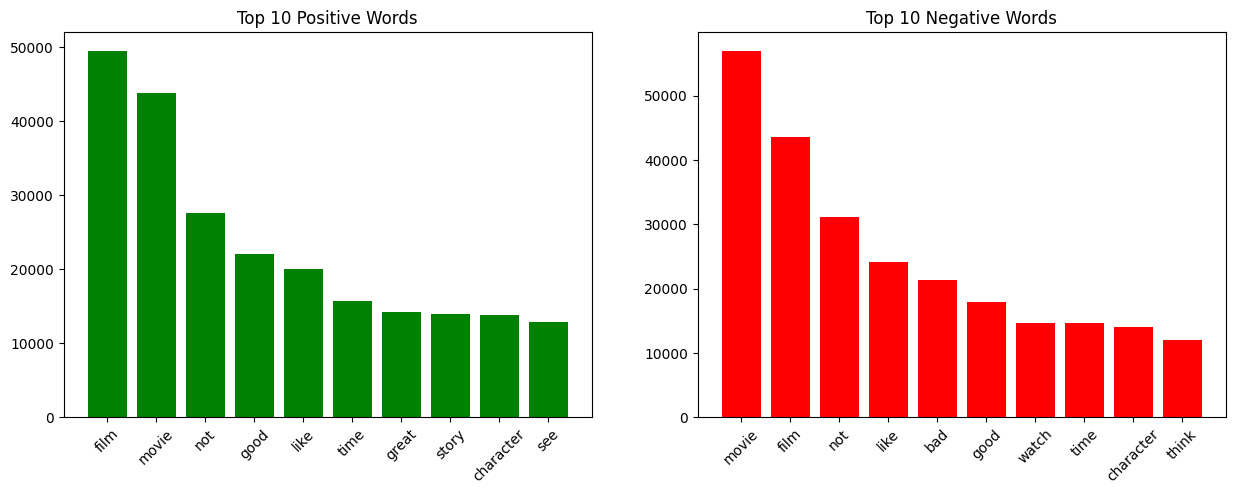

In [32]:
from collections import Counter
import matplotlib.pyplot as plt

positive_reviews = df[df['sentiment_num'] == 1]['preprocessed_review']
negative_reviews = df[df['sentiment_num'] == 0]['preprocessed_review']

positive_words = ' '.join(positive_reviews).split() # join all positive reviewes into a single string and then split this string to make a list of words
negative_words = ' '.join(negative_reviews).split()

positive_freq = Counter(positive_words) # Counter creates a dictionary with words as keys and their counts as values so it can be used with most_common() method
negative_freq = Counter(negative_words)

# Get top 10 words
top_pos = positive_freq.most_common(10) #.most_common() returns a list of tuples (word, count) ordered descendingly based on the count, so when we want to extract the word we use word for word, _ in top_pos and the reverse for count
top_neg = negative_freq.most_common(10)

plt.figure(figsize=(15, 5))

# Positive words plot
plt.subplot(1, 2, 1)
plt.bar([w for w, _ in top_pos], [c for _, c in top_pos], color='green')
plt.title('Top 10 Positive Words')
plt.xticks(rotation=45) #to tilt the labels so they dont overlap

# Negative words plot
plt.subplot(1, 2, 2)
plt.bar([w for w, _ in top_neg], [c for _, c in top_neg], color='red')
plt.title('Top 10 Negative Words')
plt.xticks(rotation=45)

plt.show()